#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature 가 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project3_1 폴더를 만들고, 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 로딩

* 라이브러리 로딩

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [11]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all' ,asd = False):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=asd,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [114]:
data_train = pd.read_csv('data01_train.csv')

In [115]:
data_test = pd.read_csv('data01_test.csv')

In [116]:
drop_cols = 'subject'
data_test.drop(columns = drop_cols ,inplace =True)
data_train.drop(columns = drop_cols, inplace = True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [20]:
print(data_train.shape)
print(data_test.shape)

(5881, 562)
(1471, 562)


In [21]:
data_test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB


In [22]:
print(data_train.describe().T)

                                       count      mean       std       min  \
tBodyAcc-mean()-X                     5881.0  0.274811  0.067614 -0.503823   
tBodyAcc-mean()-Y                     5881.0 -0.017799  0.039422 -0.684893   
tBodyAcc-mean()-Z                     5881.0 -0.109396  0.058373 -1.000000   
tBodyAcc-std()-X                      5881.0 -0.603138  0.448807 -1.000000   
tBodyAcc-std()-Y                      5881.0 -0.509815  0.501815 -0.999844   
...                                      ...       ...       ...       ...   
angle(tBodyGyroMean,gravityMean)      5881.0  0.009340  0.608190 -1.000000   
angle(tBodyGyroJerkMean,gravityMean)  5881.0 -0.007099  0.476738 -1.000000   
angle(X,gravityMean)                  5881.0 -0.491501  0.509069 -1.000000   
angle(Y,gravityMean)                  5881.0  0.059299  0.297340 -1.000000   
angle(Z,gravityMean)                  5881.0 -0.054594  0.278479 -0.980143   

                                           25%       50%       

In [23]:
print(data_test.describe().T)

                                       count      mean       std       min  \
tBodyAcc-mean()-X                     1471.0  0.273198  0.079989 -1.000000   
tBodyAcc-mean()-Y                     1471.0 -0.017281  0.045957 -1.000000   
tBodyAcc-mean()-Z                     1471.0 -0.108123  0.049082 -0.418354   
tBodyAcc-std()-X                      1471.0 -0.614634  0.448480 -0.999717   
tBodyAcc-std()-Y                      1471.0 -0.515427  0.506094 -0.999873   
...                                      ...       ...       ...       ...   
angle(tBodyGyroMean,gravityMean)      1471.0  0.006272  0.608954 -0.995222   
angle(tBodyGyroJerkMean,gravityMean)  1471.0 -0.001510  0.483028 -0.969066   
angle(X,gravityMean)                  1471.0 -0.481737  0.522714 -0.999380   
angle(Y,gravityMean)                  1471.0  0.055771  0.298124 -0.995073   
angle(Z,gravityMean)                  1471.0 -0.064194  0.281645 -1.000000   

                                           25%       50%       

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [26]:
# Acrivity 범주의 종류 확인
categories_train = data_train['Activity'].unique()
categories_test = data_test['Activity'].unique()
print("train 데이터 범주의 종류: \n", categories_train)
print("test 데이터 범주의 종류: \n", categories_train)

train 데이터 범주의 종류: 
 ['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']
test 데이터 범주의 종류: 
 ['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']


In [27]:
# 범주별 빈도수 확인
activity_count_train = data_train['Activity'].value_counts()
activity_count_test = data_test['Activity'].value_counts()
print("train 데이터 범주별 빈도수: \n", activity_count_train)
print("test 데이터 범주별 빈도수: \n", activity_count_test)

train 데이터 범주별 빈도수: 
 Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
test 데이터 범주별 빈도수: 
 Activity
LAYING                292
STANDING              287
SITTING               254
WALKING               228
WALKING_UPSTAIRS      215
WALKING_DOWNSTAIRS    195
Name: count, dtype: int64


In [28]:
# 범주별 비율 계산
activity_ratio_train = data_train['Activity'].value_counts(normalize=True)
activity_ratio_test = data_test['Activity'].value_counts(normalize=True)
print("train 데이터 범주별 비율(%) \n", activity_ratio_train)
print("test 데이터 범주별 비율(%) \n", activity_ratio_test)

train 데이터 범주별 비율(%) 
 Activity
LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: proportion, dtype: float64
test 데이터 범주별 비율(%) 
 Activity
LAYING                0.198504
STANDING              0.195105
SITTING               0.172672
WALKING               0.154997
WALKING_UPSTAIRS      0.146159
WALKING_DOWNSTAIRS    0.132563
Name: proportion, dtype: float64


In [29]:
# train , test 데이터 모두 같은 컬럼 명 , 우사한 비율로 구성되어있음 
# train 데이터에 한해서만 이변량 분석을 수행

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [120]:
data_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [122]:
#from sklearn.model_selection import train_test_split 이미 데이터가 분할되어 있으므로 쓰지 않음
target = 'Activity'
x_train = data_train.drop(columns= target)
x_test = data_test.drop(columns= target)
y_train= data_train.loc[:,target]
y_test= data_test.loc[:,target]


#### 2) 모델링

In [125]:
# 랜덤포레스트 '분류' 문제
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
model = RandomForestClassifier()

model.fit(x_train,y_train)

# 모델 성능 평가 (하지 않아도 됩니다)
y_pred = model.predict(x_test)

# 정확도 평가
print(confusion_matrix(y_test, y_pred))
print('Classification Report  \n' , classification_report(y_test, y_pred ))




[[291   1   0   0   0   0]
 [  0 244  10   0   0   0]
 [  0  11 276   0   0   0]
 [  0   0   0 224   0   4]
 [  0   0   0   2 191   2]
 [  0   0   0   0   1 214]]
Classification Report  
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.95      0.96      0.96       254
          STANDING       0.97      0.96      0.96       287
           WALKING       0.99      0.98      0.99       228
WALKING_DOWNSTAIRS       0.99      0.98      0.99       195
  WALKING_UPSTAIRS       0.97      1.00      0.98       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



#### 3) 변수 중요도 추출

In [127]:
'''
importance : 트리모델의 변수 중요도(예: model.feature_importances_)
names : 변수 이름 목록(예 : x_train.columns
result_only : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
topn : 중요도 상위 n개만 표시. all 이면 전체.
'''

tail5_feature=plot_feature_importance(model.feature_importances_, x_train.columns , result_only=True, topn=5,asd =True)
top5_feature=plot_feature_importance(model.feature_importances_, x_train.columns , result_only=True, topn=5,asd =False)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [131]:
top5_feature
# 변수간 중요도는 모델 생성시 마다 바뀌기 때문에 반드시 이게 중요하다! 라고 할 순 없다 

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.036057
1,tGravityAcc-energy()-X,0.033189
2,tGravityAcc-min()-X,0.028550
3,tGravityAcc-max()-Y,0.026313
4,tGravityAcc-min()-Y,0.024398


In [133]:
tail5_feature

,feature_name,feature_importance
0,tBodyGyroJerkMag-arCoeff()4,0.000065
1,"fBodyAcc-bandsEnergy()-57,64.1",0.000076
2,fBodyBodyAccJerkMag-entropy(),0.000089
3,fBodyBodyGyroJerkMag-min(),0.000090
4,tBodyAccJerk-mean()-Z,0.000093


#### 2) 상위 5개 변수에 대한 분석

In [136]:
def plot_kde(features, df, target, title):
    for feature in features:
        plt.figure(figsize=(6, 4))
        # 타겟 변수의 각 범주에 대해 KDE plot을 그림
        for label in df[target].unique():
            sns.kdeplot(df[feature][df[target] == label], label=f'Target: {label}', fill=True,common_norm=True)
        plt.title(f'{title} - {feature}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
        plt.tight_layout()
        plt.show()

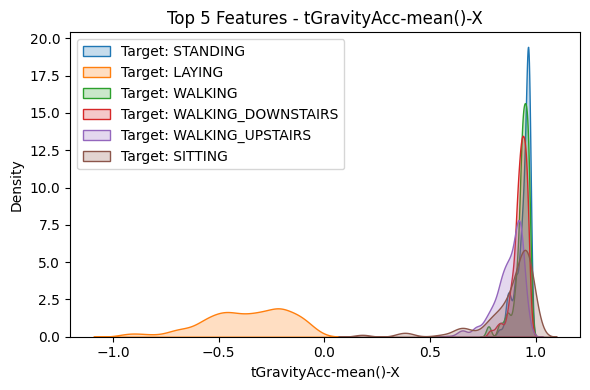

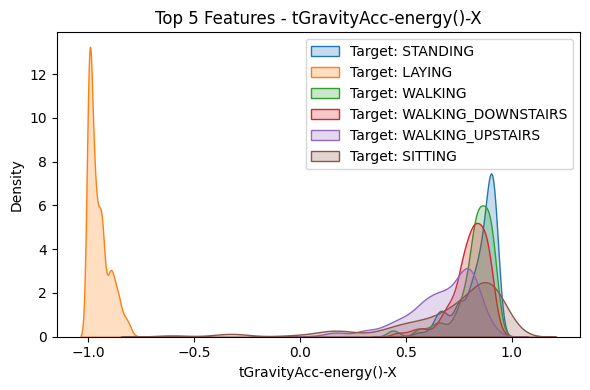

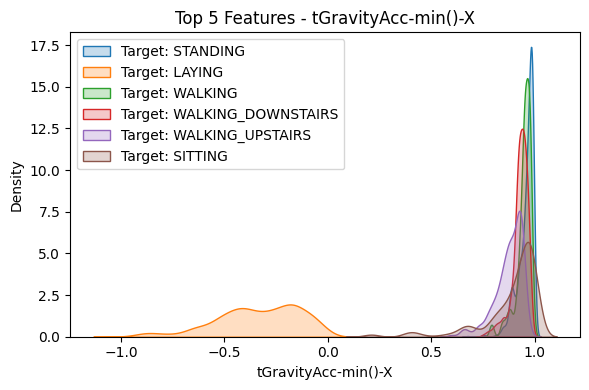

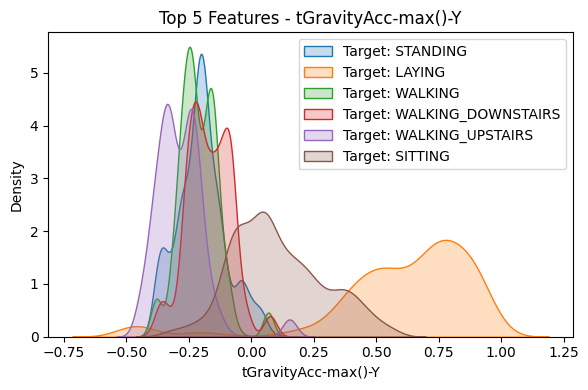

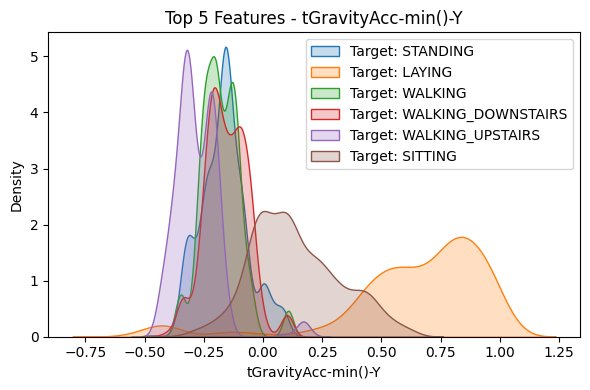

In [138]:
# 상위 5개 변수와 타겟 간의 KDE Plot
plot_kde(top5_feature['feature_name'], data_train, target, 'Top 5 Features')

In [140]:
# 상위 5개 변수들은 범주별로 확실히 구분되는 특징을 가짐 
# LAYING 누워있는거를 바로 구분 가능 

#### 3) 하위 5개 변수에 대한 분석

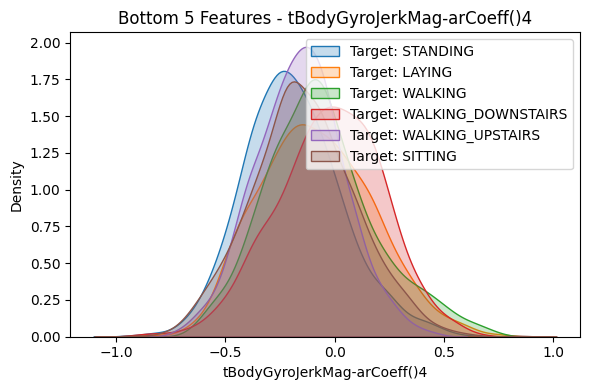

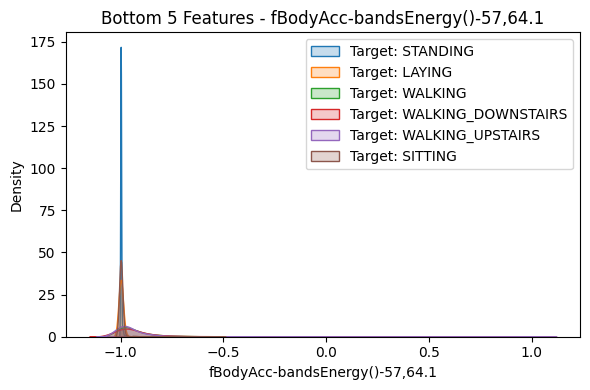

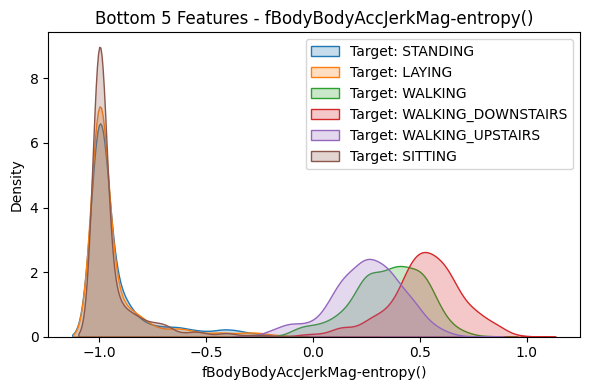

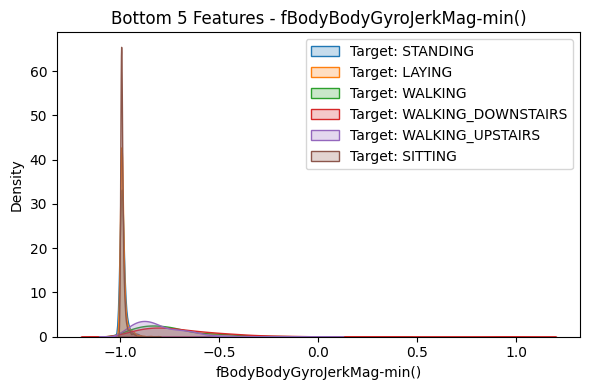

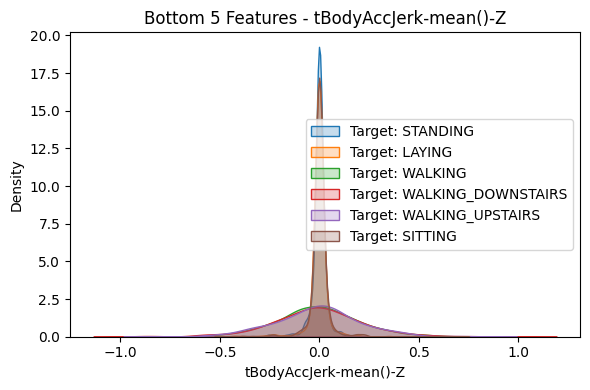

In [143]:
# 하위 5개 변수와 타겟 간의 KDE Plot
plot_kde(tail5_feature['feature_name'], data_train, target, 'Bottom 5 Features')

In [145]:
# 하위 5개 변수들은 밀도함수 분포가 곂쳐짐 > 범주별로 특성이 구분되지 않음 잘 분류할 수없음

#### 4) 결론: 중요변수는 X축 Y축 '벡터 사이 각도' & '중력 가속도'

- 상태(6가지) 중요 지표
  1. angle(X,Y , gravityMean): (X축, Y축 중력가속도 평균)벡터 사이의 각도
  2. tGravityAcc(min, max, mean,X,Y): X축 , Y축 중력가속도
 

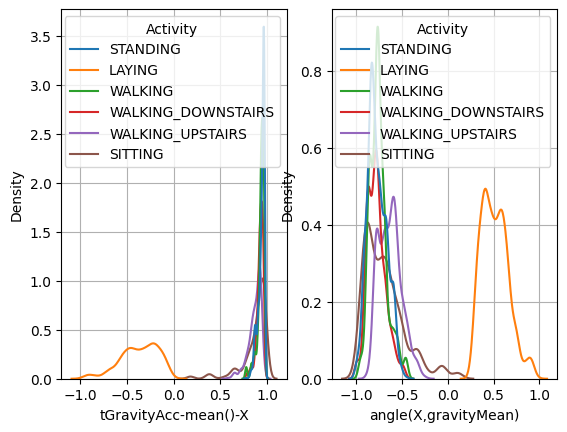

In [149]:
target = 'Activity'  

feature = 'tGravityAcc-mean()-X'
plt.subplot(1,2,1)
sns.kdeplot(x=feature, data=data_train, hue=target , common_norm = True)
plt.grid()


feature = 'angle(X,gravityMean)'
plt.subplot(1,2,2)
sns.kdeplot(x=feature, data=data_train, hue=target , common_norm = True)
plt.grid()
plt.show()

1.  tGravityAcc-mean()-X (왼쪽 그래프):

- X축에서 중력 가속도의 평균 값이 **서있기**, **앉기**, **걷기** 활동에서는 1 근처에 밀집되어 있습니다. 이는 이러한 활동 중에는 X축을 따라 중력 벡터가 안정적으로 높은 값을 유지함을 의미합니다.
반면에, 눕기는 -1 근처에서 큰 밀도를 보이며, 이는 눕는 동안 중력 방향이 X축의 음수 방향으로 정렬된다는 것을 나타냅니다.
계단 내려가기와 계단 올라가기는 정적인 활동에 비해 피크가 덜 두드러지며, 이는 이 동작 중에 중력 벡터가 더 변동이 심하다는 것을 시사합니다.

2.  angle(X,gravityMean) (오른쪽 그래프):

- 이 그래프는 X축과 중력 벡터의 평균 값 간의 각도를 나타냅니다.
눕기는 -1에서 -0.5 사이에 밀집된 값들을 보여주며, 이는 눕는 동안 몸의 중력과의 정렬이 다른 활동과 다르다는 것을 의미합니다.
서있기, 앉기, 걷기, 계단 내려가기/올라가기 같은 활동들은 양수 쪽에 밀집된 분포를 보여주며, 이는 이 활동들 동안에는 몸의 방향이 X축과 상대적으로 안정적인 상태를 유지한다는 것을 의미합니다.

3. 결론:
- **눕기**는 중력과 각도 특성이 매우 뚜렷하여 다른 활동과 쉽게 구별될 수 있으며, **서있기**, **앉기**, **걷기** 같은 활동들은 중력과의 정렬이 비교적 안정적입니다. 

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.



      *지우기 하지않음* 
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [164]:
data_train['is_dynamic'] = data_train['Activity'].replace(
    {
        'STANDING': 0,
        'SITTING': 0,
        'LAYING': 0,
        'WALKING': 1,
        'WALKING_UPSTAIRS': 1,
        'WALKING_DOWNSTAIRS': 1
        
    }
)

data_train.drop(columns = 'Activity',inplace= True)
#print(data_train.head())

data_test['is_dynamic'] = data_test['Activity'].replace(
    {
        'STANDING': 0,
        'SITTING': 0,
        'LAYING': 0,
        'WALKING': 1,
        'WALKING_UPSTAIRS': 1,
        'WALKING_DOWNSTAIRS': 1
        
    }
)

data_test.drop(columns = 'Activity',inplace= True)
#print(data_test.head())

C:\Users\User\AppData\Local\Temp\ipykernel_5696\1668436829.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train['is_dynamic'] = data_train['Activity'].replace(
C:\Users\User\AppData\Local\Temp\ipykernel_5696\1668436829.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_test['is_dynamic'] = data_test['Activity'].replace(


#### 2) 기본모델 생성

In [167]:
# 타겟 재지정 
target = 'is_dynamic'

x_train = data_train.drop(columns= target)
x_test = data_test.drop(columns= target)
y_train= data_train.loc[:,target]
y_test= data_test.loc[:,target]

In [169]:
#from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train,y_train)
# 성능평가
y_pred = model.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print('Classification Report \n' , classification_report(y_test, y_pred ))

[[833   0]
 [  0 638]]
Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471



In [170]:
# 너무 정확도가 높게 나왔는데??

#### 3) 변수중요도 상위 5개 분석

In [172]:
top5_feature=plot_feature_importance(model.feature_importances_, x_train.columns , result_only=True, topn=5)
top5_feature

,feature_name,feature_importance
0,"fBodyAccJerk-bandsEnergy()-1,16",0.060102
1,tBodyAccJerk-std()-X,0.060097
2,fBodyAccJerk-mad()-X,0.049849
3,tBodyAccJerk-sma(),0.049787
4,fBodyAccJerk-entropy()-X,0.039911


In [173]:
def plot_kde_2(features, df, target, title):
    for feature in features:
        plt.figure(figsize=(15, 4))
        # 타겟 변수의 각 범주에 대해 KDE plot을 그림
        plt.subplot(1,3,1)
        sns.kdeplot(data=df,x=feature, hue =target,common_norm=True )
        plt.xlabel(feature)
        plt.legend([f'{target}:0 ',f'{target}:1 '])

        plt.subplot(1,3,2)
        sns.kdeplot(data=df,x=feature, hue =target ,multiple ='fill' ,common_norm=True)
        plt.title(f'{title} - {feature}')
        plt.xlabel(feature)
        plt.legend([f'{target}:0 ',f'{target}:1 '])
        
        plt.subplot(1,3,3)
        sns.boxplot(data=df,x=feature, hue =target )
        plt.xlabel(feature)
        plt.legend([f'{target}:0 ',f'{target}:1 '])
        
        plt.show()

In [174]:
def plot_boxplot(features, df, target, title):
    for feature in features:
        plt.figure(figsize=(15, 4))
        # 타겟 변수의 각 범주에 대해 boxplot을 그림
        sns.boxplot(data=df,x=feature, hue =target )
        plt.title(f'{title} - {feature}')
        plt.xlabel(feature)
        plt.legend([f'{target}:0 ',f'{target}:1 '])
        
        plt.show()

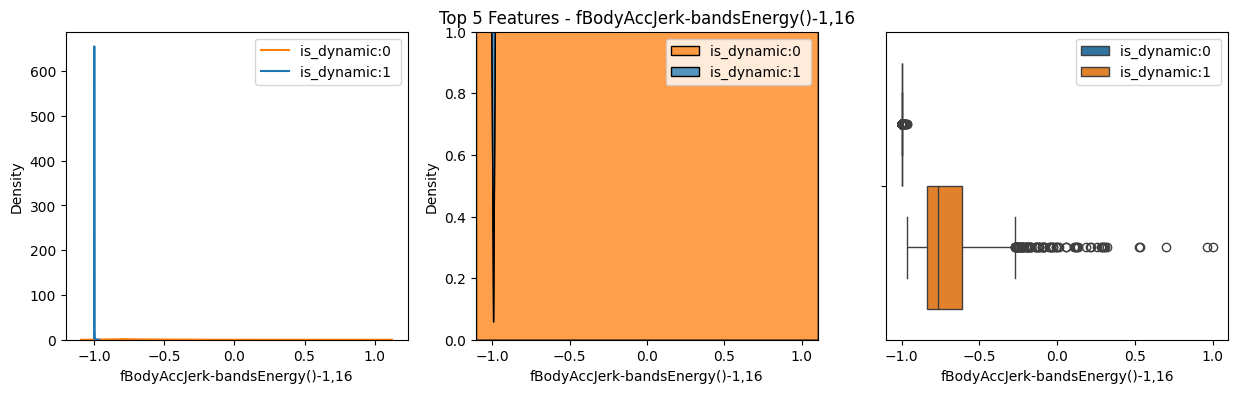

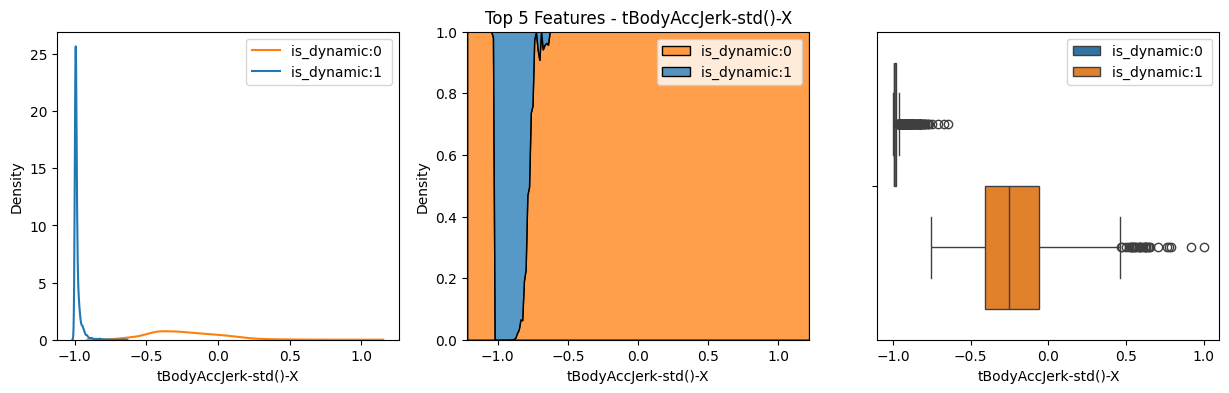

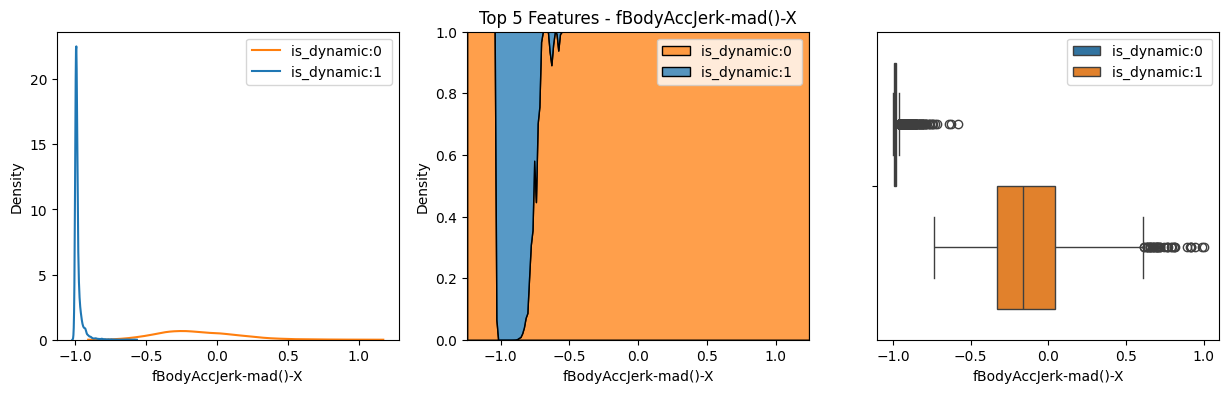

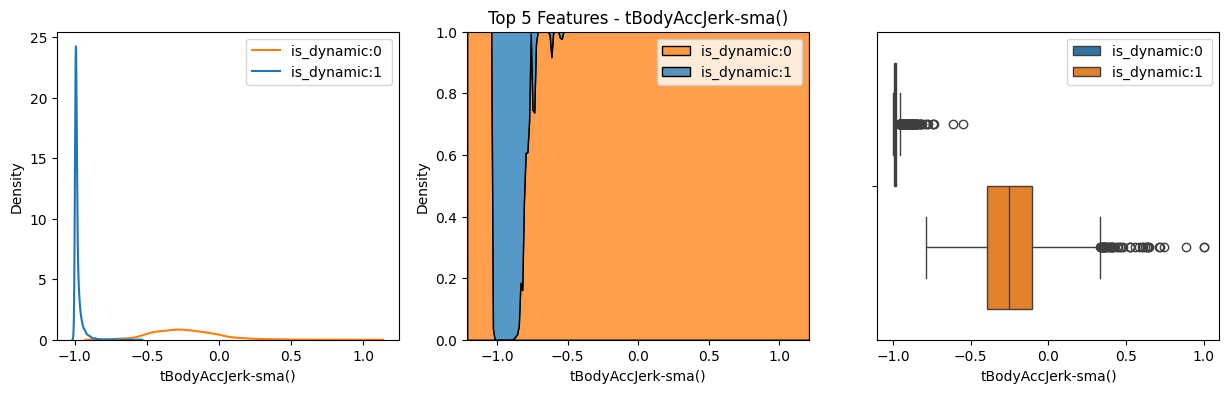

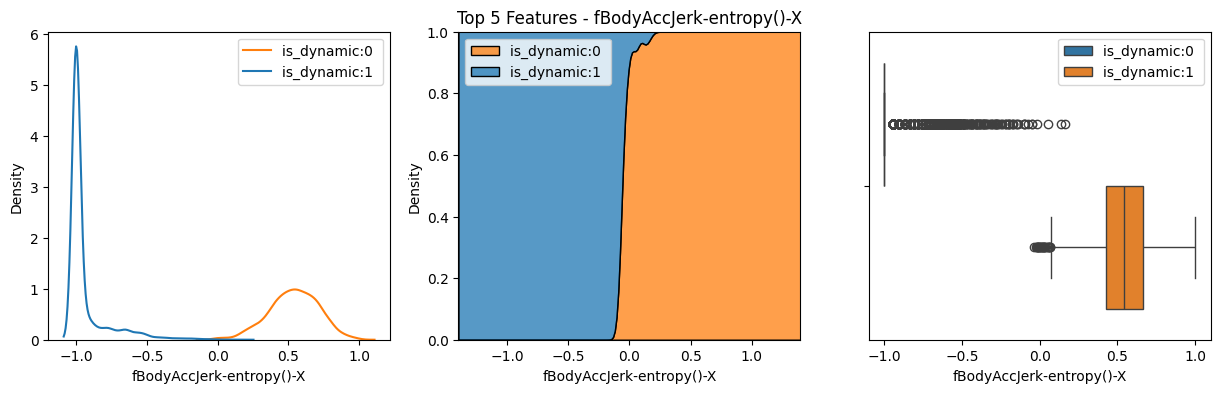

In [175]:
# 상위 5개 변수와 타겟 간의 KDE Plot
plot_kde_2(top5_feature['feature_name'], data_train, target, 'Top 5 Features')

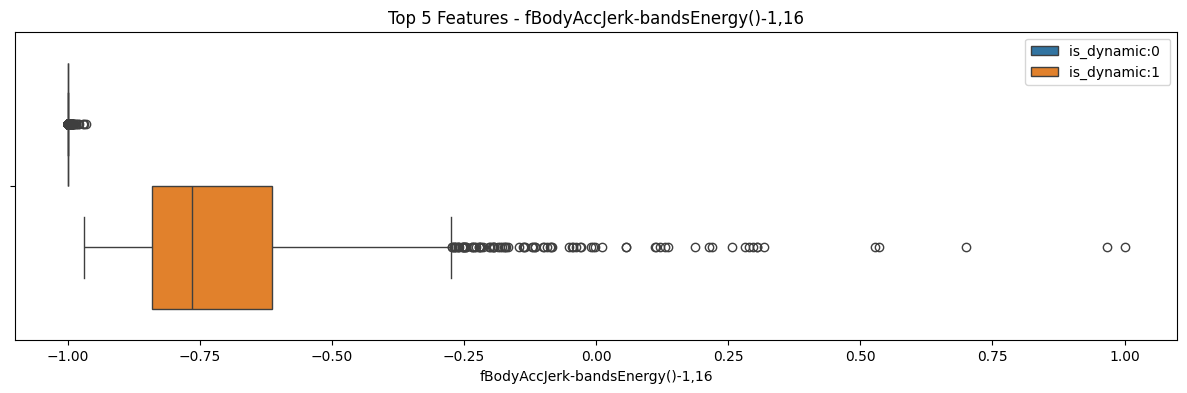

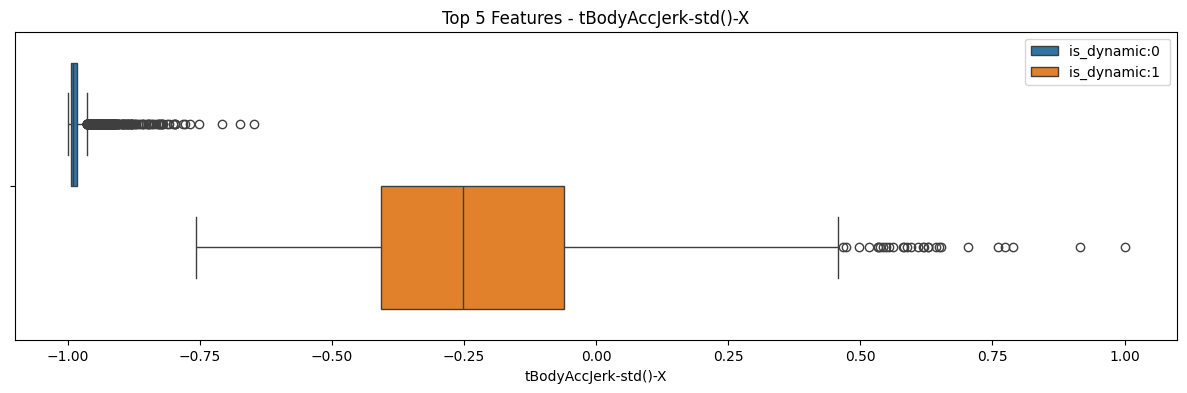

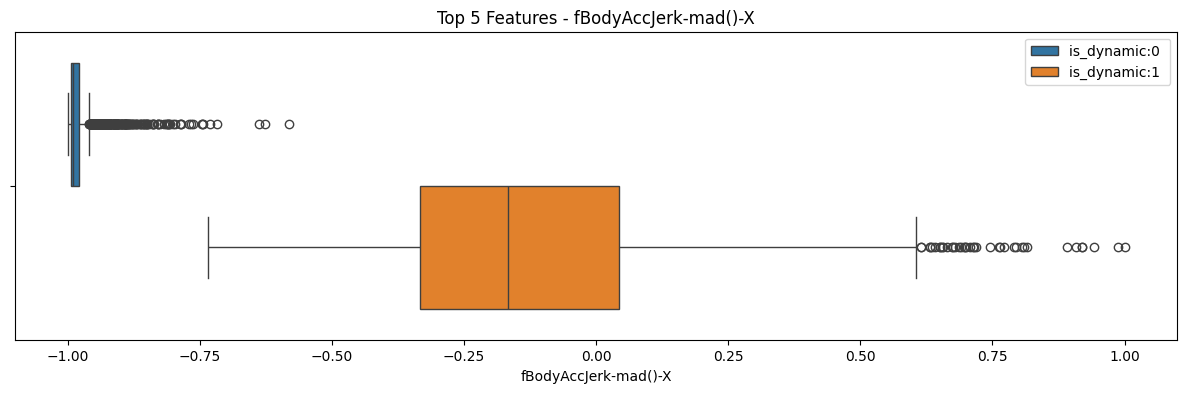

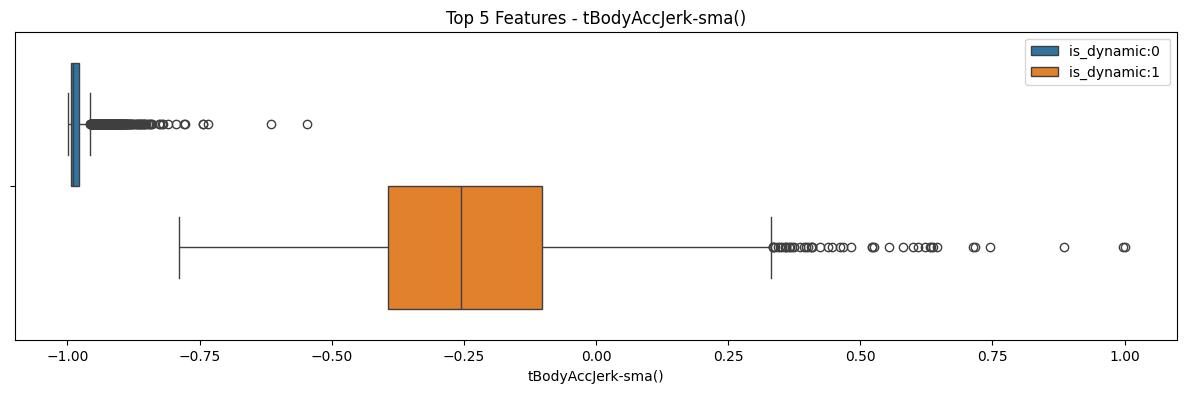

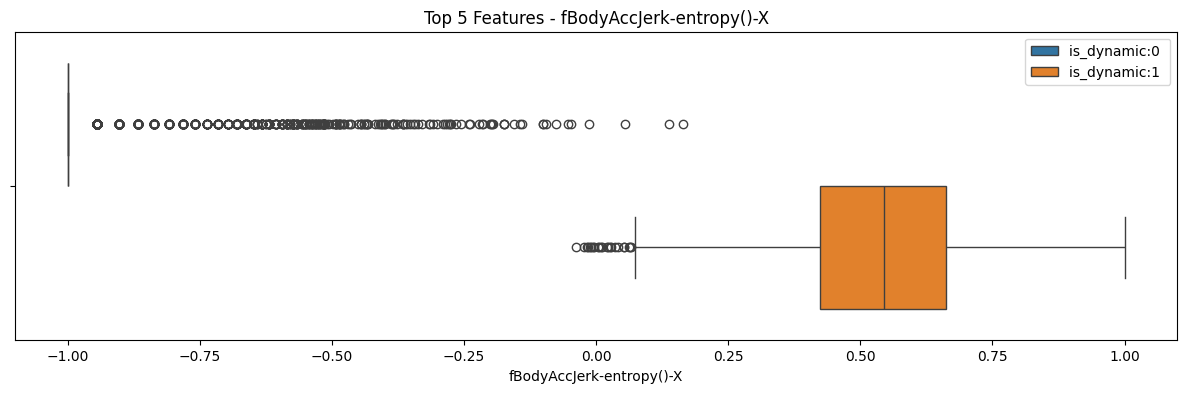

In [176]:
plot_boxplot(top5_feature['feature_name'], data_train, target, 'Top 5 Features')

In [177]:
bottom5_feature=plot_feature_importance(model.feature_importances_, x_train.columns , result_only=True, topn=5 ,asd= True)
bottom5_feature

,feature_name,feature_importance
0,tBodyAcc-mean()-X,0.0
1,fBodyAccJerk-mad()-Z,0.0
2,fBodyAccJerk-std()-Z,0.0
3,fBodyAccJerk-std()-Y,0.0
4,fBodyAccJerk-mean()-Z,0.0


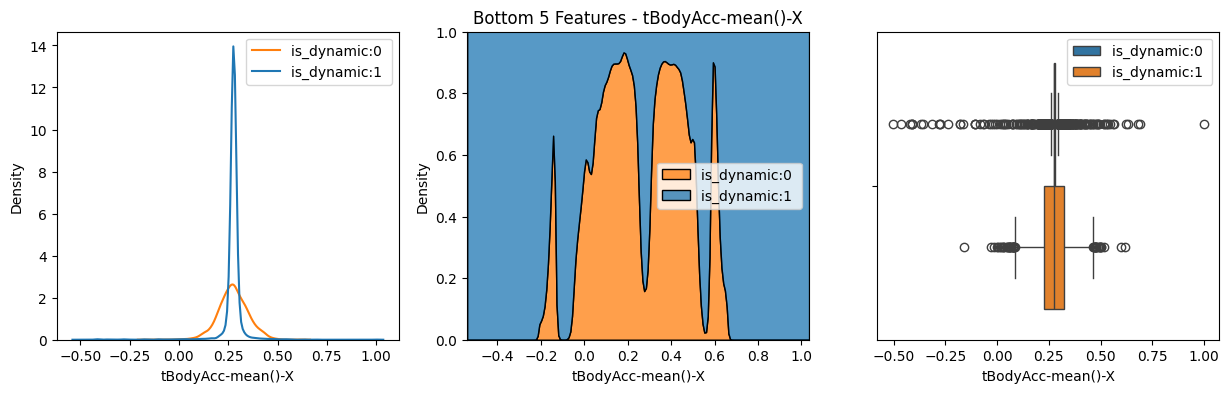

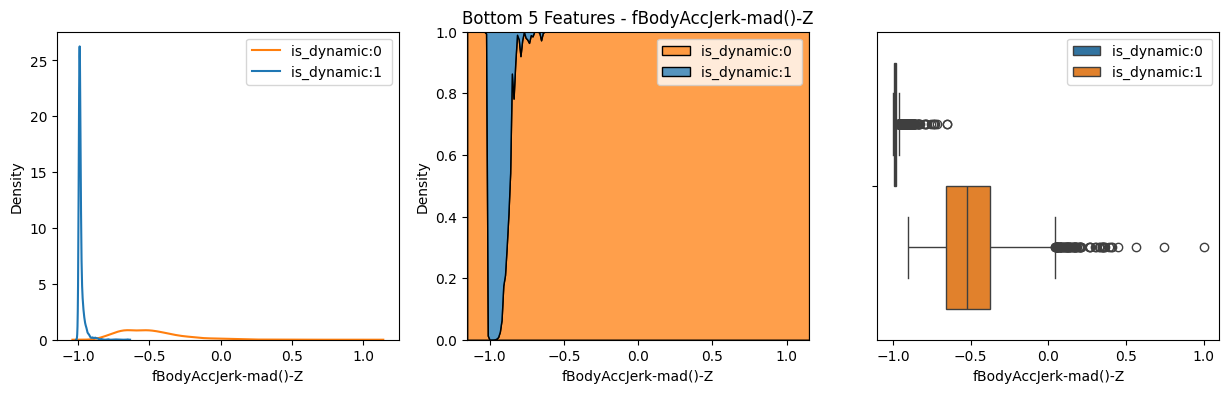

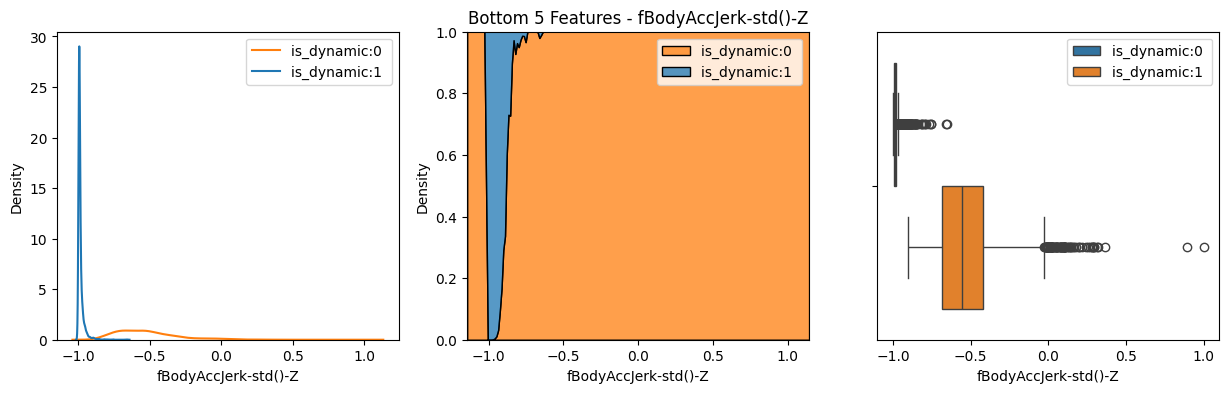

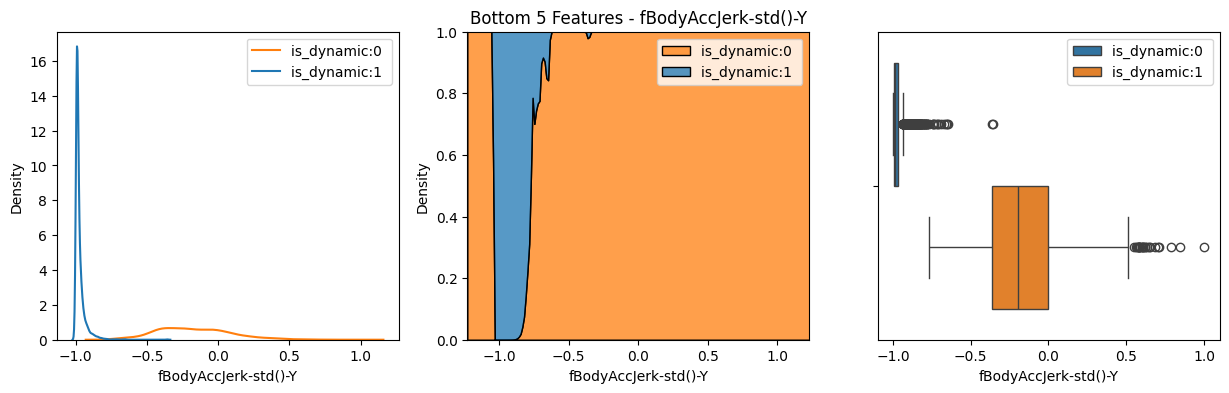

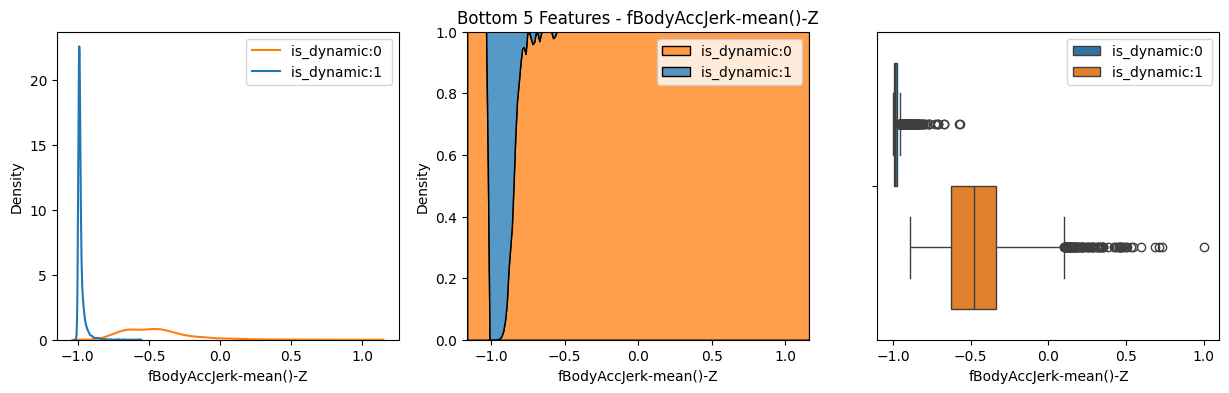

In [178]:
# 하위 5개 변수와 타겟 간의 KDE Plot
plot_kde_2(bottom5_feature['feature_name'], data_train, target, 'Bottom 5 Features')

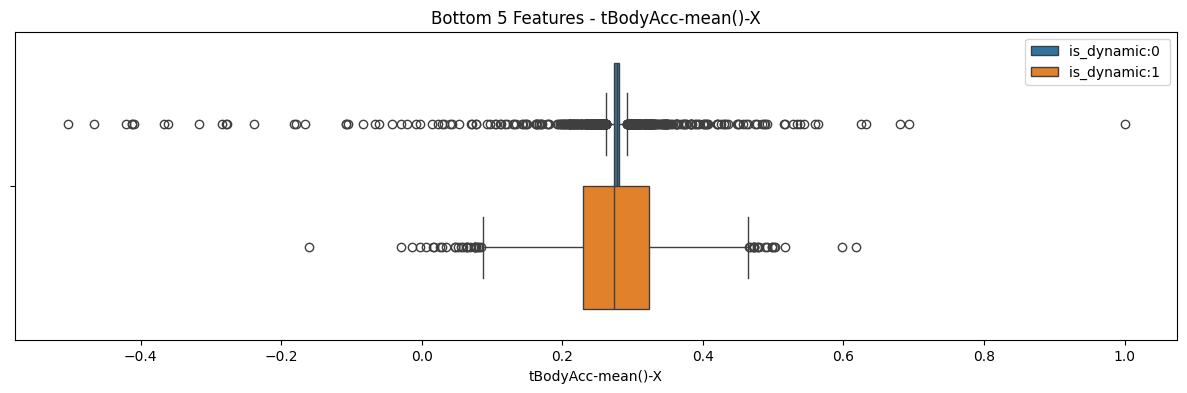

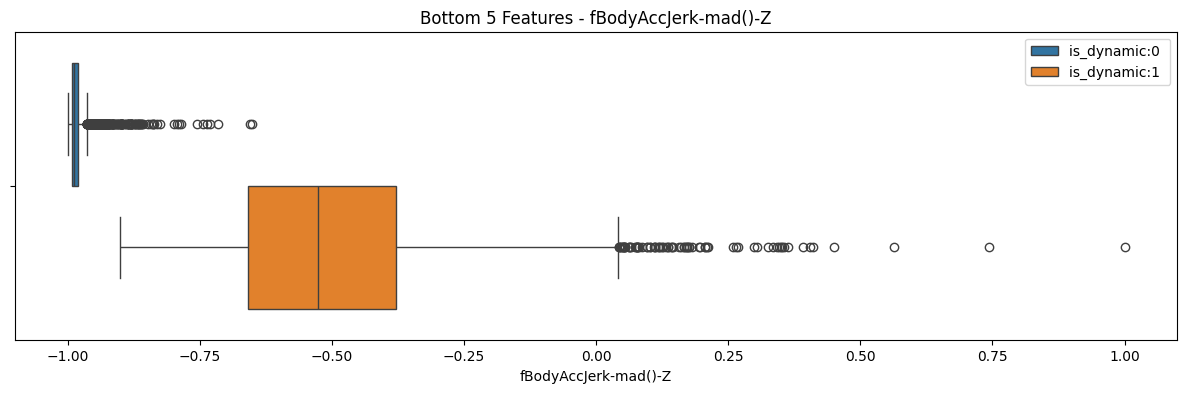

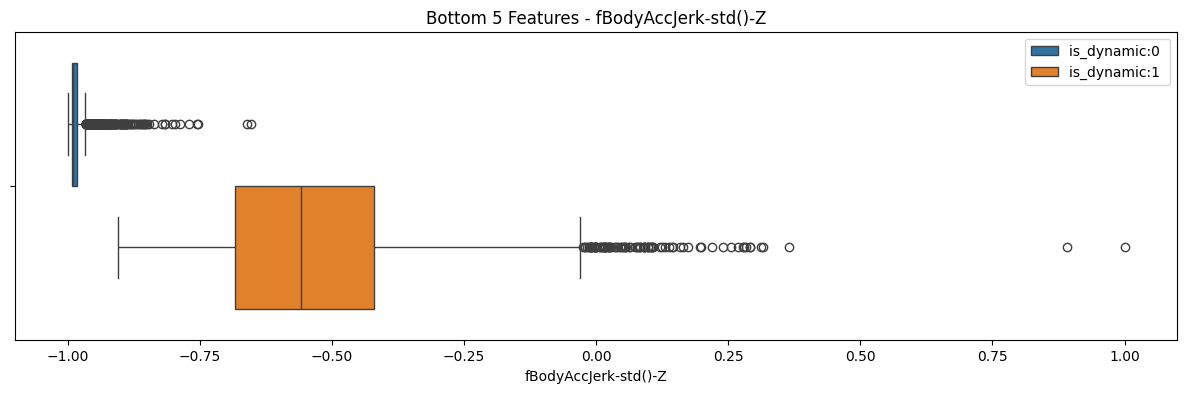

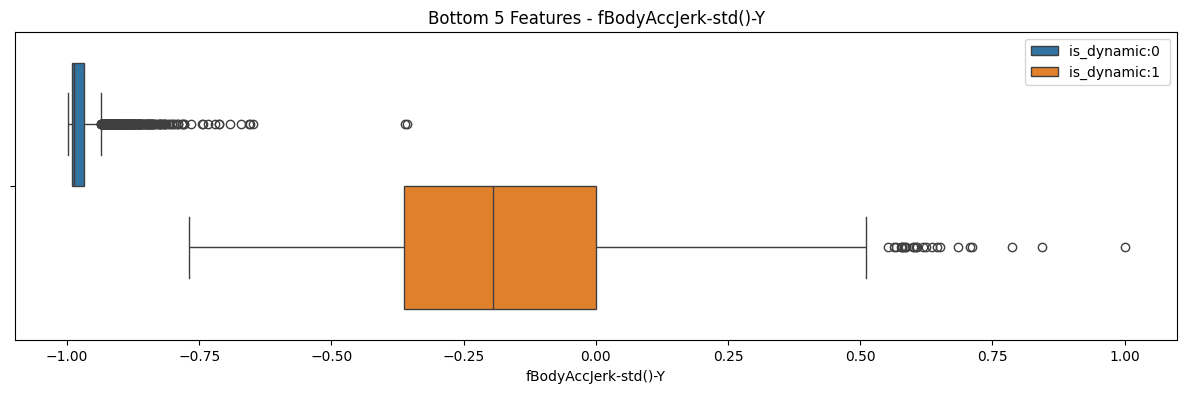

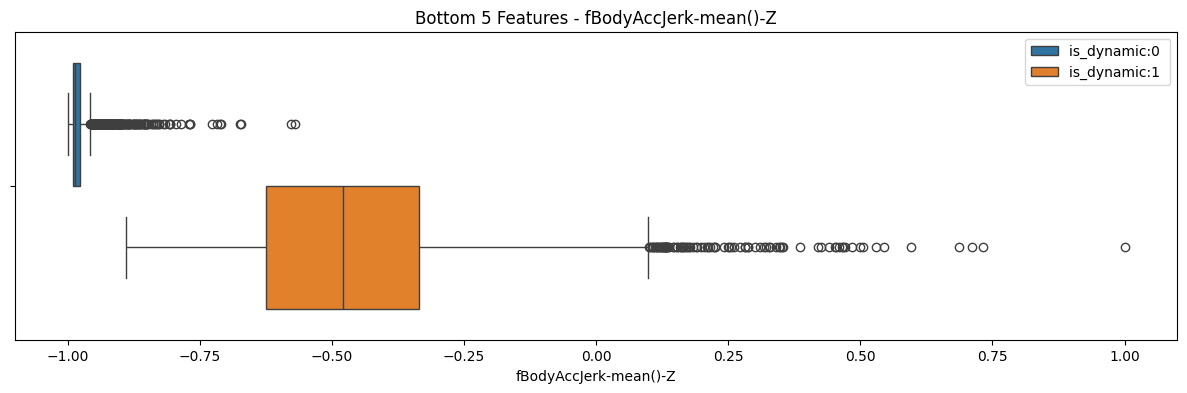

In [179]:
plot_boxplot(bottom5_feature['feature_name'], data_train, target, 'Bottom 5 Features')

#### 4) 결론: 중요변수는 'X축 방향 가속도 변화비율'

1. tBodyAccJerk-(min,max,mean,energy....)-X : 'X축 방향 가속도 변화비율'

In [187]:
top5_feature

,feature_name,feature_importance
0,"fBodyAccJerk-bandsEnergy()-1,16",0.060102
1,tBodyAccJerk-std()-X,0.060097
2,fBodyAccJerk-mad()-X,0.049849
3,tBodyAccJerk-sma(),0.049787
4,fBodyAccJerk-entropy()-X,0.039911


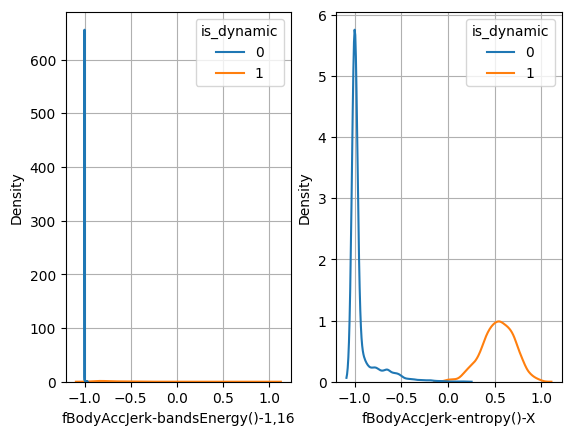

In [196]:
target = 'is_dynamic'  

feature = 'fBodyAccJerk-bandsEnergy()-1,16'
plt.subplot(1,2,1)
sns.kdeplot(x=feature, data=data_train, hue=target , common_norm = True)
plt.grid()



feature = 'fBodyAccJerk-entropy()-X'
plt.subplot(1,2,2)
sns.kdeplot(x=feature, data=data_train, hue=target , common_norm = True)
plt.grid()
plt.show()


- **fBodyAccJerk-bandsEnergy()** 는 정적 상태를 매우 잘 구분해 주지만, 동적 상태에서는 차이가 거의 없습니다.
  
- 반면에, **fBodyAccJerk-entropy()** 는 동적 상태와 정적 상태를 더 뚜렷하게 구분해 주며, 동적 상태에서 엔트로피가 더 높다는 점에서 유의미한 차이를 보입니다. 

-  **fBodyAccJerk-entropy()** 는 동적 상태를 판별하는 데 더 유용한 변수로 보입니다.